In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
!unzip -u /gdrive/MyDrive/marketgad/tiny-imagenet-200.zip -d /content/

Streaming output truncated to the last 5000 lines.
  inflating: /content/tiny-imagenet-200/val/images/val_5500.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5501.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5502.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5503.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5504.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5505.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5506.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5507.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5508.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5509.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_551.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5510.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5511.JPEG  
  inflating: /content/tiny-imagenet-200/val/images/val_5512.JPEG  
  inflating:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
# from keras_contrib.callbacks import CyclicLR

In [ ]:
val_csv = pd.read_csv('tiny-imagenet-200/val/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_csv.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_csv.head()

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727
3,val_3.JPEG,n02808440
4,val_4.JPEG,n02808440


# DATA AUGMENTATION

In [ ]:
TARGET=(64,64)
train_datagen=ImageDataGenerator(rescale=1./255,
                                 rotation_range=40,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 shear_range=0.2,
                                 zoom_range=0.2,
                                 horizontal_flip=True,
                                 vertical_flip=True,
                                 fill_mode='nearest')
valid_datagen=ImageDataGenerator(rescale=1./255)
                                                  
train_generator=train_datagen.flow_from_directory("tiny-imagenet-200/train/",target_size=TARGET,class_mode='categorical',
                                                  batch_size=256)


valid_generator=valid_datagen.flow_from_dataframe(val_csv, directory='tiny-imagenet-200/val/images/', x_col='File', y_col='Class', target_size=TARGET,
                                                class_mode='categorical', batch_size=256)

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.


In [ ]:
IMG_SHAPE=(64,64,3)
model=tf.keras.applications.DenseNet121(input_shape=IMG_SHAPE,
                           include_top=False,
                          weights=None)
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
final_model = keras.Sequential([
            model,
            keras.layers.Flatten(),
            keras.layers.Dense(512,activation="relu"),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(200, activation='softmax')
])

# CALLBACKS

In [ ]:
model_checkpoint = keras.callbacks.ModelCheckpoint(
    '/gdrive/MyDrive/marketgad/best_weights6.h5',
    monitor="val_loss",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode="min",
)

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode="min",
    restore_best_weights=True,
)
reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=np.sqrt(0.1),
    patience=4,
    verbose=1,
    mode="min",
    min_delta=0.001
)

In [ ]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 2, 2, 1024)        7037504   
_________________________________________________________________
flatten_2 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 200)               102600    
Total params: 9,237,768
Trainable params: 9,154,120
Non-trainable params: 83,648
_________________________________________________________________


# DENSENET121

In [ ]:
history=final_model.fit(train_generator,steps_per_epoch=100000//256,validation_data=valid_generator,
                  validation_steps=10000//256,epochs=50,callbacks = [model_checkpoint, early_stopping, reduce_lr])

Epoch 1/50
390/390 [==============================] - 179s 429ms/step - loss: 5.2224 - accuracy: 0.0141 - val_loss: 5.1625 - val_accuracy: 0.0214

Epoch 00001: val_loss improved from inf to 5.16247, saving model to /gdrive/MyDrive/marketgad/best_weights.h5
Epoch 2/50
390/390 [==============================] - 164s 421ms/step - loss: 4.7836 - accuracy: 0.0415 - val_loss: 5.2989 - val_accuracy: 0.0050

Epoch 00002: val_loss did not improve from 5.16247
Epoch 3/50
390/390 [==============================] - 164s 421ms/step - loss: 4.6332 - accuracy: 0.0585 - val_loss: 5.0707 - val_accuracy: 0.0471

Epoch 00003: val_loss improved from 5.16247 to 5.07073, saving model to /gdrive/MyDrive/marketgad/best_weights.h5
Epoch 4/50
390/390 [==============================] - 164s 421ms/step - loss: 4.5066 - accuracy: 0.0714 - val_loss: 5.4909 - val_accuracy: 0.0312

Epoch 00004: val_loss did not improve from 5.07073
Epoch 5/50
390/390 [==============================] - 164s 421ms/step - loss: 4.4129 -

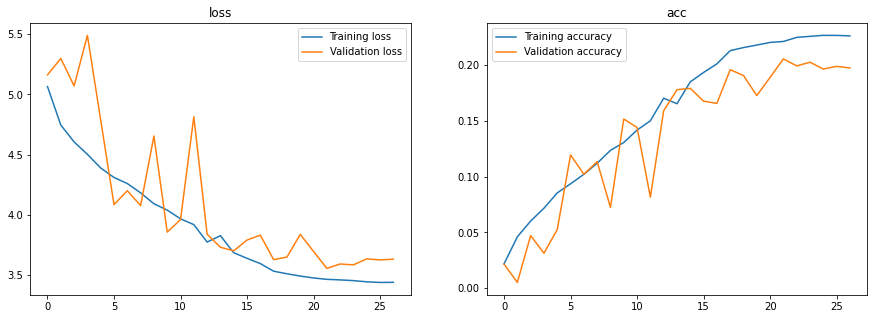

In [ ]:
def show_final_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    ax[0].set_title('loss')
    ax[0].plot(history.epoch, history.history["loss"], label="Training loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")
    ax[1].set_title('acc')
    ax[1].plot(history.epoch, history.history["accuracy"], label="Training accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation accuracy")
    ax[0].legend()
    ax[1].legend()
show_final_history(history)

# DENSNET121 with CyclicLR

In [ ]:
clr = CyclicLR(base_lr=0.00001, max_lr=0.00006, step_size=4686., mode='triangular2')

final_model.load_weights('/gdrive/MyDrive/marketgad/best_weights.h5')
history=final_model.fit(train_generator,steps_per_epoch=100000//256,validation_data=valid_generator,
                  validation_steps=10000//256,epochs=50,callbacks = [model_checkpoint, early_stopping, clr])

Epoch 1/50
390/390 [==============================] - 165s 423ms/step - loss: 3.4567 - accuracy: 0.2255 - val_loss: 3.6447 - val_accuracy: 0.1961

Epoch 00001: val_loss did not improve from 3.64460
Epoch 2/50
390/390 [==============================] - 165s 424ms/step - loss: 3.4551 - accuracy: 0.2238 - val_loss: 3.6358 - val_accuracy: 0.1976

Epoch 00002: val_loss improved from 3.64460 to 3.63576, saving model to /gdrive/MyDrive/marketgad/best_weights1.h5
Epoch 3/50
390/390 [==============================] - 165s 423ms/step - loss: 3.4521 - accuracy: 0.2249 - val_loss: 3.6578 - val_accuracy: 0.1945

Epoch 00003: val_loss did not improve from 3.63576
Epoch 4/50
390/390 [==============================] - 166s 424ms/step - loss: 3.4486 - accuracy: 0.2255 - val_loss: 3.6382 - val_accuracy: 0.1978

Epoch 00004: val_loss did not improve from 3.63576
Epoch 5/50
390/390 [==============================] - 165s 423ms/step - loss: 3.4438 - accuracy: 0.2269 - val_loss: 3.6497 - val_accuracy: 0.197

KeyboardInterrupt: ignored

In [ ]:
show_final_history(history)

# DENSENET169

In [ ]:
IMG_SHAPE=(64,64,3)
model=tf.keras.applications.DenseNet169(input_shape=IMG_SHAPE,
                           include_top=False,
                          weights=None)
model.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 70, 70, 3)    0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
final_model = keras.Sequential([
            model,
            keras.layers.GlobalAveragePooling2D(),
            # keras.layers.Dense(512,activation="relu"),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(200, activation='softmax')
])

In [ ]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet169 (Functional)     (None, 2, 2, 1664)        12642880  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1664)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1664)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               333000    
Total params: 12,975,880
Trainable params: 12,817,480
Non-trainable params: 158,400
_________________________________________________________________


In [ ]:
history=final_model.fit(train_generator,steps_per_epoch=100000//256,validation_data=valid_generator,
                  validation_steps=10000//256,epochs=50,callbacks = [model_checkpoint, early_stopping, reduce_lr])

Epoch 1/50
390/390 [==============================] - 193s 455ms/step - loss: 5.1482 - accuracy: 0.0286 - val_loss: 156.7360 - val_accuracy: 0.0053

Epoch 00001: val_loss improved from inf to 156.73601, saving model to /gdrive/MyDrive/marketgad/best_weights2.h5
Epoch 2/50
390/390 [==============================] - 175s 449ms/step - loss: 4.4982 - accuracy: 0.0765 - val_loss: 5.2712 - val_accuracy: 0.0644

Epoch 00002: val_loss improved from 156.73601 to 5.27116, saving model to /gdrive/MyDrive/marketgad/best_weights2.h5
Epoch 3/50
390/390 [==============================] - 175s 449ms/step - loss: 4.2106 - accuracy: 0.1120 - val_loss: 5.5162 - val_accuracy: 0.0363

Epoch 00003: val_loss did not improve from 5.27116
Epoch 4/50
390/390 [==============================] - 175s 448ms/step - loss: 3.9619 - accuracy: 0.1461 - val_loss: 4.7145 - val_accuracy: 0.0823

Epoch 00004: val_loss improved from 5.27116 to 4.71445, saving model to /gdrive/MyDrive/marketgad/best_weights2.h5
Epoch 5/50
390

In [ ]:
show_final_history(history)

# DENSENET201

In [ ]:
IMG_SHAPE=(64,64,3)
model=tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                           include_top=False,
                            weights=None)
model.summary()

Model: "densenet201"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 3)    0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
final_model = keras.Sequential([
            model,
            keras.layers.GlobalAveragePooling2D(),
            # keras.layers.Dense(512,activation="relu"),
            keras.layers.Dropout(0.6),
            keras.layers.Dense(200, activation='softmax')
])

In [ ]:
final_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
final_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 2, 2, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 1920)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1920)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 200)               384200    
Total params: 18,706,184
Trainable params: 18,477,128
Non-trainable params: 229,056
_________________________________________________________________


In [ ]:
history=final_model.fit(train_generator,steps_per_epoch=100000//256,validation_data=valid_generator,
                  validation_steps=10000//256,epochs=50,callbacks = [model_checkpoint, early_stopping, reduce_lr])

Epoch 1/50
390/390 [==============================] - 206s 488ms/step - loss: 5.2673 - accuracy: 0.0251 - val_loss: 6.8733 - val_accuracy: 0.0159

Epoch 00001: val_loss improved from inf to 6.87333, saving model to /gdrive/MyDrive/marketgad/best_weights6.h5
Epoch 2/50
390/390 [==============================] - 189s 483ms/step - loss: 4.6920 - accuracy: 0.0589 - val_loss: 1207.5026 - val_accuracy: 0.0101

Epoch 00002: val_loss did not improve from 6.87333
Epoch 3/50
390/390 [==============================] - 187s 480ms/step - loss: 4.4611 - accuracy: 0.0803 - val_loss: 4.8241 - val_accuracy: 0.0593

Epoch 00003: val_loss improved from 6.87333 to 4.82409, saving model to /gdrive/MyDrive/marketgad/best_weights6.h5
Epoch 4/50
390/390 [==============================] - 187s 480ms/step - loss: 4.2001 - accuracy: 0.1119 - val_loss: 4.3846 - val_accuracy: 0.0938

Epoch 00004: val_loss improved from 4.82409 to 4.38458, saving model to /gdrive/MyDrive/marketgad/best_weights6.h5
Epoch 5/50
390/39

In [ ]:
show_final_history(history)

# INCEPTION-RESNET-V2

In [ ]:
IMG_SHAPE=(75,75,3)
model=tf.keras.applications.InceptionResNetV2(input_shape=IMG_SHAPE,
                           include_top=False,
                          weights=None)
model.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 37, 37, 32)   864         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_203 (BatchN (None, 37, 37, 32)   96          conv2d_203[0][0]                 
__________________________________________________________________________________________________
activation_203 (Activation)     (None, 37, 37, 32)   0           batch_normalization_203[0][0]    
________________________________________________________________________________

In [ ]:
final_model = keras.Sequential([
            model,
            keras.layers.GlobalAveragePooling2D(),
            # keras.layers.Dense(512,activation="relu"),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(200, activation='softmax')
])
final_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])

Epoch 1/50
390/390 [==============================] - 239s 575ms/step - loss: 5.0963 - accuracy: 0.0359 - val_loss: 4.9839 - val_accuracy: 0.0292

Epoch 00001: val_loss improved from inf to 4.98386, saving model to /gdrive/MyDrive/marketgad/best_weights4.h5
Epoch 2/50
390/390 [==============================] - 223s 570ms/step - loss: 4.3996 - accuracy: 0.0995 - val_loss: 16.9891 - val_accuracy: 0.0812

Epoch 00002: val_loss did not improve from 4.98386
Epoch 3/50
390/390 [==============================] - 222s 570ms/step - loss: 4.2126 - accuracy: 0.1232 - val_loss: 78.5174 - val_accuracy: 0.0732

Epoch 00003: val_loss did not improve from 4.98386

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
Epoch 4/50
390/390 [==============================] - 221s 567ms/step - loss: 3.9341 - accuracy: 0.1616 - val_loss: 3.8463 - val_accuracy: 0.1857

Epoch 00004: val_loss improved from 4.98386 to 3.84634, saving model to /gdrive/MyDrive/marketgad/best_weights4.h5
E

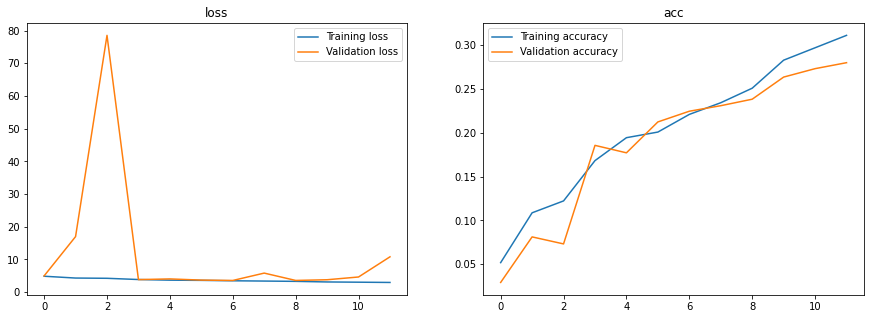

In [ ]:
history=final_model.fit(train_generator,steps_per_epoch=100000//256,validation_data=valid_generator,
                  validation_steps=10000//256,epochs=50,callbacks = [model_checkpoint, early_stopping, reduce_lr])
show_final_history(history)

# EVALUATE


In [1]:
IMG_SHAPE=(64,64,3)
model=tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                           include_top=False,
                            weights=None)
model.summary()

NameError: ignored

In [2]:
final_model = keras.Sequential([
            model,
            keras.layers.GlobalAveragePooling2D(),
            # keras.layers.Dense(512,activation="relu"),
            keras.layers.Dropout(0.4),
            keras.layers.Dense(200, activation='softmax')
])

NameError: ignored

In [ ]:
valid_datagen = ImageDataGenerator(rescale=1./255)
valid_generator = valid_datagen.flow_from_dataframe(val_csv, directory='tiny-imagenet-200/val/images/', x_col='File',
                                                    y_col='Class', target_size=(64, 64),class_mode='categorical',batch_size=32)

In [ ]:
final_model.load_weights('/gdrive/MyDrive/marketgad/best_weights3.h5')
final_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=1)])
score=final_model.evaluate(valid_generator, steps=10000//32)
print('Top-1 loss:', score[0])
print('Top-1 accuracy:', score[1])

In [ ]:
final_model.load_weights('/gdrive/MyDrive/marketgad/best_weights3.h5')
final_model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=[tf.keras.metrics.TopKCategoricalAccuracy(k=5)])
score=final_model.evaluate(valid_generator, steps=10000//32)
print('Top-5 loss:', score[0])
print('Top-5 accuracy:', score[1])